# CSET419 – Introduction to Generative AI  
## Lab 3: Variational Autoencoder (VAE)

### Objective
The objective of this lab is to understand and implement a Variational Autoencoder (VAE) to:
- Learn latent representations of data  
- Generate new and diverse data samples  
- Understand the role of encoder, decoder, latent space, and KL-divergence

### Dataset
MNIST handwritten digit dataset


# Import required libraries

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


## Task 1: Dataset Preparation

In this step, the Fashion-MNIST dataset is loaded and preprocessed.  
The images are normalized and split into training and testing datasets
to prepare them for training the Variational Autoencoder.


In [2]:
# Define transformation: convert images to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Load MNIST testing dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


## Task 2: Encoder Network

The encoder network compresses the input image into a latent representation.
Instead of producing a single value, it learns the mean and log-variance of
the latent distribution, which are later used for sampling.


In [3]:
# Define the Encoder network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)

        h = torch.relu(self.fc1(x))

        # Compute mean and log-variance
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar


## Reparameterization Trick

The reparameterization trick allows the model to sample latent variables
from a distribution while still enabling gradient-based optimization.
This step is essential for training a Variational Autoencoder.


In [4]:
# Reparameterization trick
def reparameterize(mu, logvar):
    # Convert log variance to standard deviation
    std = torch.exp(0.5 * logvar)

    # Sample random noise
    eps = torch.randn_like(std)

    # Generate latent vector
    z = mu + eps * std
    return z


## Task 2: Decoder Network

The decoder network reconstructs the input image from the sampled latent vector.
It maps the latent representation back to the original image space.


In [5]:
# Define the Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28 * 28)

    def forward(self, z):
        h = torch.relu(self.fc1(z))

        # Output values between 0 and 1
        x_recon = torch.sigmoid(self.fc2(h))

        return x_recon


## Task 2: Variational Autoencoder Model

This section combines the encoder, reparameterization trick, and decoder
into a single Variational Autoencoder (VAE) model.


In [6]:
# Define the full VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # Encode the input
        mu, logvar = self.encoder(x)

        # Sample latent vector
        z = reparameterize(mu, logvar)

        # Decode the latent vector
        x_recon = self.decoder(z)

        return x_recon, mu, logvar


## Task 3: Loss Function

The VAE loss function consists of two components:
1. Reconstruction Loss, which measures how well the output matches the input.
2. KL Divergence Loss, which regularizes the latent space.


In [7]:
# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x,
        x.view(x.size(0), -1),
        reduction='sum'
    )

    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # Total loss
    total_loss = recon_loss + kl_loss
    return total_loss


## Task 4: Model Initialization

In this step, the Variational Autoencoder model is initialized,
and the optimizer is defined to prepare the model for training.


In [8]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define latent dimension
latent_dim = 20

# Initialize model
model = VAE(latent_dim).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Task 4: Training the VAE

In this step, the VAE model is trained on the Fashion-MNIST dataset.
The training loss is monitored over multiple epochs to observe learning behavior.


In [9]:
# Training parameters
epochs = 30

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)

        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/30], Loss: 164.6158
Epoch [2/30], Loss: 121.6167
Epoch [3/30], Loss: 114.6666
Epoch [4/30], Loss: 111.6867
Epoch [5/30], Loss: 109.9524
Epoch [6/30], Loss: 108.8023
Epoch [7/30], Loss: 107.9357
Epoch [8/30], Loss: 107.3322
Epoch [9/30], Loss: 106.8258
Epoch [10/30], Loss: 106.4067
Epoch [11/30], Loss: 106.0502
Epoch [12/30], Loss: 105.7224
Epoch [13/30], Loss: 105.4959
Epoch [14/30], Loss: 105.2604
Epoch [15/30], Loss: 105.0185
Epoch [16/30], Loss: 104.8781
Epoch [17/30], Loss: 104.6624
Epoch [18/30], Loss: 104.5178
Epoch [19/30], Loss: 104.3943
Epoch [20/30], Loss: 104.2304
Epoch [21/30], Loss: 104.0330
Epoch [22/30], Loss: 103.9251
Epoch [23/30], Loss: 103.8488
Epoch [24/30], Loss: 103.7348
Epoch [25/30], Loss: 103.5526
Epoch [26/30], Loss: 103.5014
Epoch [27/30], Loss: 103.3639
Epoch [28/30], Loss: 103.3147
Epoch [29/30], Loss: 103.1941
Epoch [30/30], Loss: 103.1322


## Task 5: Sample Generation

In this step, new images are generated by sampling random latent vectors
from a standard normal distribution and passing them through the decoder
of the trained Variational Autoencoder.


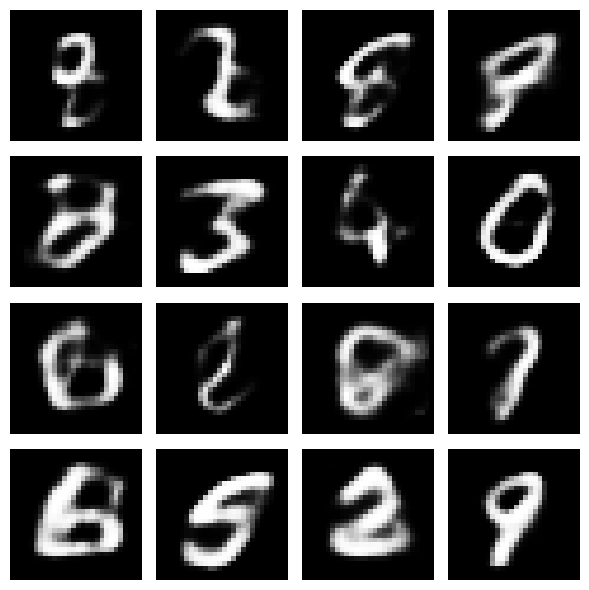

In [10]:
# Set model to evaluation mode
model.eval()

# Number of samples to generate
num_samples = 16

with torch.no_grad():
    # Sample random latent vectors
    z = torch.randn(num_samples, latent_dim).to(device)

    # Generate images using the decoder
    generated_images = model.decoder(z)

    # Reshape for visualization
    generated_images = generated_images.view(num_samples, 28, 28).cpu()

# Plot generated images
plt.figure(figsize=(6, 6))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Task 6: Latent Space Visualization

This step visualizes the latent space learned by the VAE by reducing the
latent dimension to two and plotting the encoded representations of the data.


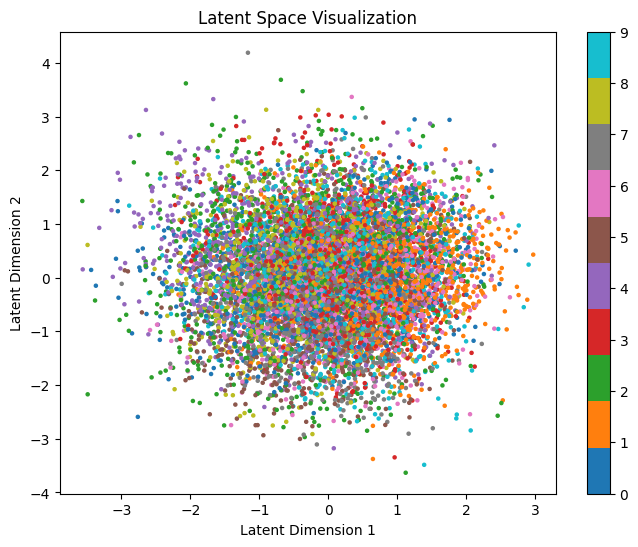

In [11]:
# This visualization works only if latent_dim = 2

model.eval()

latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        mu, logvar = model.encoder(images)
        z = reparameterize(mu, logvar)

        latent_vectors.append(z.cpu().numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors)
labels_list = np.concatenate(labels_list)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
            c=labels_list, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()
